AMV Historical Data

In [1]:
# Install necessary packages
!pip install pandas numpy matplotlib seaborn scikit-learn lightgbm tensorflow

'pip' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import joblib

sns.set_theme()

In [3]:
# Load and preprocess the data
df = pd.read_csv('AMV Historical Data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)
df = df.replace(',', '', regex=True)

In [4]:
def convert_volume_to_number(volume_str):
    # Check if input is already a float
    if isinstance(volume_str, float):
        return volume_str  # Return float values unchanged
    
    # Handle string inputs
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)

# Apply the function to the "Vol." column
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

In [5]:
def convert_to_numeric(value):
    if isinstance(value, str):
        value = value.strip()
        if value.endswith('%'):
            try:
                return float(value[:-1]) / 100.0  # Convert percentage to float
            except ValueError:
                return value  # Return original value if conversion fails
        elif value.isdigit():
            return int(value)  # Convert integer strings to integers
        elif '.' in value:
            try:
                return float(value)  # Convert decimal strings to float
            except ValueError:
                return value  # Return original value if conversion fails
    return value  # Return value unchanged if it's not a string or couldn't be converted

In [6]:
# Apply the conversion to the entire dataframe
df = df.applymap(convert_to_numeric)

C:\Users\miynzi\AppData\Local\Temp\ipykernel_7204\638310794.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(convert_to_numeric)


In [7]:
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,15225.0,15270.0,15315.0,15180.0,4700,-0.0029
2019-03-04,14865.0,15180.0,15180.0,14865.0,19010,-0.0236
2019-03-05,14414.0,14865.0,15045.0,14414.0,48800,-0.0303
2019-03-06,14594.0,14414.0,14684.0,14414.0,17250,0.0125
2019-03-07,14144.0,14594.0,14594.0,14144.0,28810,-0.0308
...,...,...,...,...,...,...
2024-05-27,3500.0,3500.0,3600.0,3500.0,660470,0.0000
2024-05-28,3500.0,3500.0,3600.0,3500.0,452540,0.0000
2024-05-29,3500.0,3500.0,3600.0,3500.0,522679,0.0000


In [8]:
print(df.dtypes)

Price       float64
Open        float64
High        float64
Low         float64
Vol.          int64
Change %    float64
dtype: object


In [9]:
# Select features and target
features = df[['Open', 'High', 'Low', 'Price']].values
target = df['Price'].values

In [10]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(np.array(target).reshape(-1, 1))

In [11]:
# Split data into training and testing sets
train_size = int(0.9 * len(scaled_target))
test_size = len(scaled_target) - train_size

train_features = scaled_features[:train_size]
train_target = scaled_target[:train_size]
test_features = scaled_features[train_size:]
test_target = scaled_target[train_size:]

In [12]:
# Function to create dataset matrix
def create_dataset(features, target, time_step=1):
    dataX, dataY = [], []
    for i in range(len(target) - time_step - 1):
        a = features[i:(i + time_step)]
        dataX.append(a)
        dataY.append(target[i + time_step])
    return np.array(dataX), np.array(dataY)

In [13]:
# Create training and testing datasets
time_step = 30
X_train, y_train = create_dataset(train_features, train_target, time_step)
X_test, y_test = create_dataset(test_features, test_target, time_step)

In [14]:
# Reshape input to be [samples, time steps, features] for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

In [15]:
# Build and train LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
lstm_model.add(LSTM(50, return_sequences=True))
lstm_model.add(LSTM(50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100


c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0702 - val_loss: 0.0021
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0074 - val_loss: 8.7203e-05
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0061 - val_loss: 1.5003e-04
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0063 - val_loss: 7.0097e-05
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0057 - val_loss: 5.7798e-05
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0064 - val_loss: 7.3155e-05
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0056 - val_loss: 1.3297e-04
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0053 - val_loss: 5.3415e-05
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0036 - val_loss: 1.4615e-04
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0057 - val_loss: 1.2873e-04
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0043 - val_loss: 6.5293e-05
Epoch 12/100
18/18 ━━━━━

In [16]:
# Extract features from LSTM for LightGBM
train_features_lstm = lstm_model.predict(X_train)
test_features_lstm = lstm_model.predict(X_test)

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [17]:
# Prepare data for LightGBM
train_data_lgb = lgb.Dataset(train_features_lstm, label=y_train)
test_data_lgb = lgb.Dataset(test_features_lstm, label=y_test, reference=train_data_lgb)

In [18]:
# LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': -1,
    'num_boost_round': 200
}

In [19]:
# Train LightGBM model with early stopping
evals_result = {}
callbacks = [
    lgb.early_stopping(stopping_rounds=10),
    lgb.record_evaluation(evals_result)
]

lgb_model = lgb.train(
    params,
    train_data_lgb,
    num_boost_round=params['num_boost_round'],
    valid_sets=[train_data_lgb, test_data_lgb],
    valid_names=['train', 'valid'],
    callbacks=callbacks
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 1150, number of used features: 1
[LightGBM] [Info] Start training from score 0.406741
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.0444778	valid's rmse: 0.0496652


c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\basic.py:335: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


In [20]:
# Predict using LightGBM
y_pred = lgb_model.predict(test_features_lstm, num_iteration=lgb_model.best_iteration)

In [21]:
# Define evaluation metric functions
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [22]:
# Calculate evaluation metrics
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
msle = mean_squared_log_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

In [23]:
# Print evaluation metrics
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')
print(f'Mean Squared Logarithmic Error (MSLE): {msle}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')

Root Mean Squared Error (RMSE): 0.049665202898436664
Mean Absolute Percentage Error (MAPE): 127.45660464215898%
Mean Squared Logarithmic Error (MSLE): 0.002157867986394049
Mean Squared Error (MSE): 0.0024666323789428817
Mean Absolute Error (MAE): 0.049296551574245014


In [24]:
# Function to predict future days using LSTM and LightGBM
def predict_future_days(lstm_model, lgb_model, initial_data, days=30, time_step=30):
    predictions = []
    input_data = initial_data.copy()

    for _ in range(days):
        # Predict features using LSTM
        lstm_features = lstm_model.predict(input_data)

        # Predict the next day's closing price using LightGBM
        next_close = lgb_model.predict(lstm_features)

        # Append the prediction
        predictions.append(next_close[0])

        # Update the initial data with the new prediction
        new_feature = np.zeros((1, time_step, input_data.shape[2]))
        new_feature[:, :-1, :] = input_data[:, 1:, :]
        new_feature[:, -1, 0] = next_close  # Assuming the next_close is for 'Price'
        input_data = new_feature

    return predictions

In [25]:
# Generate the initial data for prediction (last window of the test set)
initial_data = X_test[-1].reshape(1, X_test.shape[1], X_test.shape[2])

In [26]:
# Predict next 30, 60, and 90 days
next_30_days_predictions = predict_future_days(lstm_model, lgb_model, initial_data, days=30)
next_60_days_predictions = predict_future_days(lstm_model, lgb_model, initial_data, days=60)
next_90_days_predictions = predict_future_days(lstm_model, lgb_model, initial_data, days=90)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

In [27]:
# Inverse transform the predictions
next_30_days_predictions = scaler.inverse_transform(np.array(next_30_days_predictions).reshape(-1, 1))
next_60_days_predictions = scaler.inverse_transform(np.array(next_60_days_predictions).reshape(-1, 1))
next_90_days_predictions = scaler.inverse_transform(np.array(next_90_days_predictions).reshape(-1, 1))

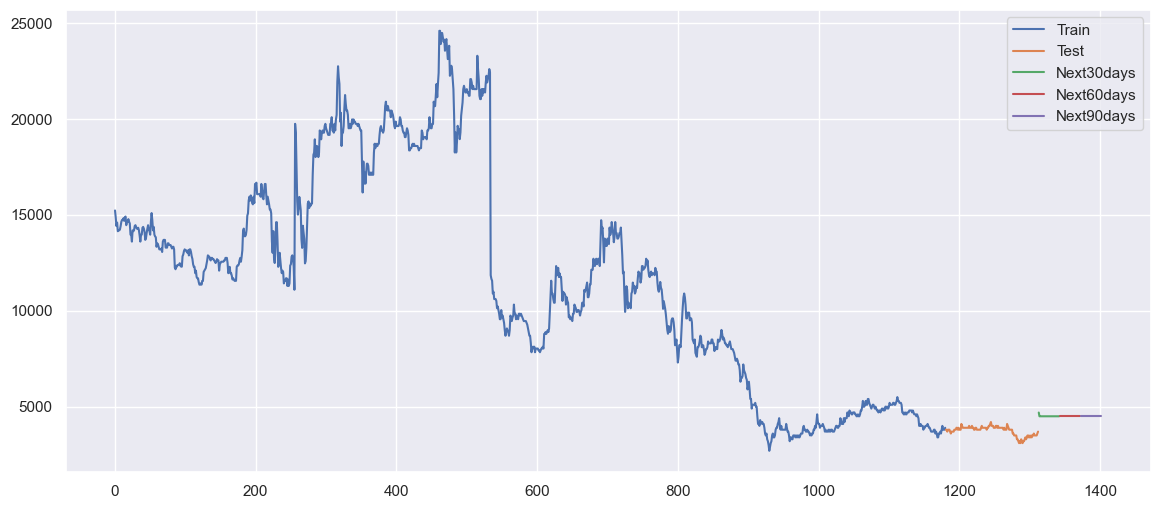

In [28]:
# Plotting train, test, and prediction data
plt.figure(figsize=(14, 6))

# Plotting the training data
train_data_index = pd.RangeIndex(start=0, stop=len(train_target), step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_target), label='Train')

# Plotting the testing data
test_data_index = pd.RangeIndex(start=len(train_target), stop=len(train_target) + len(test_target), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_target), label='Test')

# Creating data indices for predictions
predict_30_data_index = pd.RangeIndex(start=len(df), stop=len(df) + 30, step=1)
plt.plot(predict_30_data_index, next_30_days_predictions, label='Predict30days')

predict_60_data_index = pd.RangeIndex(start=len(df) + 30, stop=len(df) + 60, step=1)
plt.plot(predict_60_data_index, next_60_days_predictions[30:], label='Predict60days')

predict_90_data_index = pd.RangeIndex(start=len(df) + 60, stop=len(df) + 90, step=1)
plt.plot(predict_90_data_index, next_90_days_predictions[60:], label='Predict90days')

plt.legend(['Train', 'Test', 'Next30days', 'Next60days', 'Next90days'])
plt.show()

DHT Historical Data

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import joblib

sns.set_theme()

In [30]:
# Load and preprocess the data
df = pd.read_csv('DHT Historical Data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)
df = df.replace(',', '', regex=True)

In [31]:
def convert_volume_to_number(volume_str):
    # Check if input is already a float
    if isinstance(volume_str, float):
        return volume_str  # Return float values unchanged
    
    # Handle string inputs
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)

# Apply the function to the "Vol." column
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

In [32]:
def convert_to_numeric(value):
    if isinstance(value, str):
        value = value.strip()
        if value.endswith('%'):
            try:
                return float(value[:-1]) / 100.0  # Convert percentage to float
            except ValueError:
                return value  # Return original value if conversion fails
        elif value.isdigit():
            return int(value)  # Convert integer strings to integers
        elif '.' in value:
            try:
                return float(value)  # Convert decimal strings to float
            except ValueError:
                return value  # Return original value if conversion fails
    return value  # Return value unchanged if it's not a string or couldn't be converted

In [33]:
# Apply the conversion to the entire dataframe
df = df.applymap(convert_to_numeric)

C:\Users\miynzi\AppData\Local\Temp\ipykernel_7204\638310794.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(convert_to_numeric)


In [34]:
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,10860.1,10916.2,11224.9,10663.6,138720,0.0184
2019-03-04,11224.9,11056.5,11477.4,11056.5,296000,0.0336
2019-03-05,11337.1,11224.9,11365.2,10888.1,308000,0.0100
2019-03-06,11561.6,11309.1,11589.7,11309.1,292910,0.0198
2019-03-07,11589.7,11842.2,11842.2,11224.9,240150,0.0024
...,...,...,...,...,...,...
2024-05-27,38600.0,35200.0,39900.0,35200.0,133260,0.0604
2024-05-28,39300.0,38600.0,39500.0,38200.0,61630,0.0181
2024-05-29,39500.0,39900.0,39900.0,38300.0,107350,0.0051


In [35]:
print(df.dtypes)

Price       float64
Open        float64
High        float64
Low         float64
Vol.          int64
Change %    float64
dtype: object


In [36]:
# Select features and target
features = df[['Open', 'High', 'Low', 'Price']].values
target = df['Price'].values

In [37]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(np.array(target).reshape(-1, 1))

In [38]:
# Split data into training and testing sets
train_size = int(0.9 * len(scaled_target))
test_size = len(scaled_target) - train_size

train_features = scaled_features[:train_size]
train_target = scaled_target[:train_size]
test_features = scaled_features[train_size:]
test_target = scaled_target[train_size:]

In [39]:
# Function to create dataset matrix
def create_dataset(features, target, time_step=1):
    dataX, dataY = [], []
    for i in range(len(target) - time_step - 1):
        a = features[i:(i + time_step)]
        dataX.append(a)
        dataY.append(target[i + time_step])
    return np.array(dataX), np.array(dataY)

In [40]:
# Create training and testing datasets
time_step = 30
X_train, y_train = create_dataset(train_features, train_target, time_step)
X_test, y_test = create_dataset(test_features, test_target, time_step)

In [41]:
# Reshape input to be [samples, time steps, features] for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

In [42]:
# Build and train LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
lstm_model.add(LSTM(50, return_sequences=True))
lstm_model.add(LSTM(50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100


c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0282 - val_loss: 0.0486
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0023 - val_loss: 0.0105
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0022 - val_loss: 0.0072
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0014 - val_loss: 0.0088
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0014 - val_loss: 0.0147
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0015 - val_loss: 0.0101
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0016 - val_loss: 0.0084
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0011 - val_loss: 0.0060
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0010 - val_loss: 0.0060
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 9.8953e-04 - val_loss: 0.0054
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0011 - val_loss: 0.0129
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss:

In [43]:
# Extract features from LSTM for LightGBM
train_features_lstm = lstm_model.predict(X_train)
test_features_lstm = lstm_model.predict(X_test)

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [44]:
# Prepare data for LightGBM
train_data_lgb = lgb.Dataset(train_features_lstm, label=y_train)
test_data_lgb = lgb.Dataset(test_features_lstm, label=y_test, reference=train_data_lgb)

In [45]:
# LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': -1,
    'num_boost_round': 200
}

In [46]:
# Train LightGBM model with early stopping
evals_result = {}
callbacks = [
    lgb.early_stopping(stopping_rounds=10),
    lgb.record_evaluation(evals_result)
]

lgb_model = lgb.train(
    params,
    train_data_lgb,
    num_boost_round=params['num_boost_round'],
    valid_sets=[train_data_lgb, test_data_lgb],
    valid_names=['train', 'valid'],
    callbacks=callbacks
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 1149, number of used features: 1
[LightGBM] [Info] Start training from score 0.217860
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 0.0190416	valid's rmse: 0.1365


c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\basic.py:335: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


In [47]:
# Predict using LightGBM
y_pred = lgb_model.predict(test_features_lstm, num_iteration=lgb_model.best_iteration)

In [48]:
# Define evaluation metric functions
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [49]:
# Calculate evaluation metrics
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
msle = mean_squared_log_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

In [50]:
# Print evaluation metrics
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')
print(f'Mean Squared Logarithmic Error (MSLE): {msle}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')

Root Mean Squared Error (RMSE): 0.13650022892065497
Mean Absolute Percentage Error (MAPE): 15.121965457062766%
Mean Squared Logarithmic Error (MSLE): 0.006580336750419012
Mean Squared Error (MSE): 0.018632312495391212
Mean Absolute Error (MAE): 0.08938100772028654


In [51]:
# Function to predict future days using LSTM and LightGBM
def predict_future_days(lstm_model, lgb_model, initial_data, days=30, time_step=30):
    predictions = []
    input_data = initial_data.copy()

    for _ in range(days):
        # Predict features using LSTM
        lstm_features = lstm_model.predict(input_data)

        # Predict the next day's closing price using LightGBM
        next_close = lgb_model.predict(lstm_features)

        # Append the prediction
        predictions.append(next_close[0])

        # Update the initial data with the new prediction
        new_feature = np.zeros((1, time_step, input_data.shape[2]))
        new_feature[:, :-1, :] = input_data[:, 1:, :]
        new_feature[:, -1, 0] = next_close  # Assuming the next_close is for 'Price'
        input_data = new_feature

    return predictions

In [52]:
# Generate the initial data for prediction (last window of the test set)
initial_data = X_test[-1].reshape(1, X_test.shape[1], X_test.shape[2])

In [53]:
# Predict next 30, 60, and 90 days
next_30_days_predictions = predict_future_days(lstm_model, lgb_model, initial_data, days=30)
next_60_days_predictions = predict_future_days(lstm_model, lgb_model, initial_data, days=60)
next_90_days_predictions = predict_future_days(lstm_model, lgb_model, initial_data, days=90)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

In [54]:
# Inverse transform the predictions
next_30_days_predictions = scaler.inverse_transform(np.array(next_30_days_predictions).reshape(-1, 1))
next_60_days_predictions = scaler.inverse_transform(np.array(next_60_days_predictions).reshape(-1, 1))
next_90_days_predictions = scaler.inverse_transform(np.array(next_90_days_predictions).reshape(-1, 1))

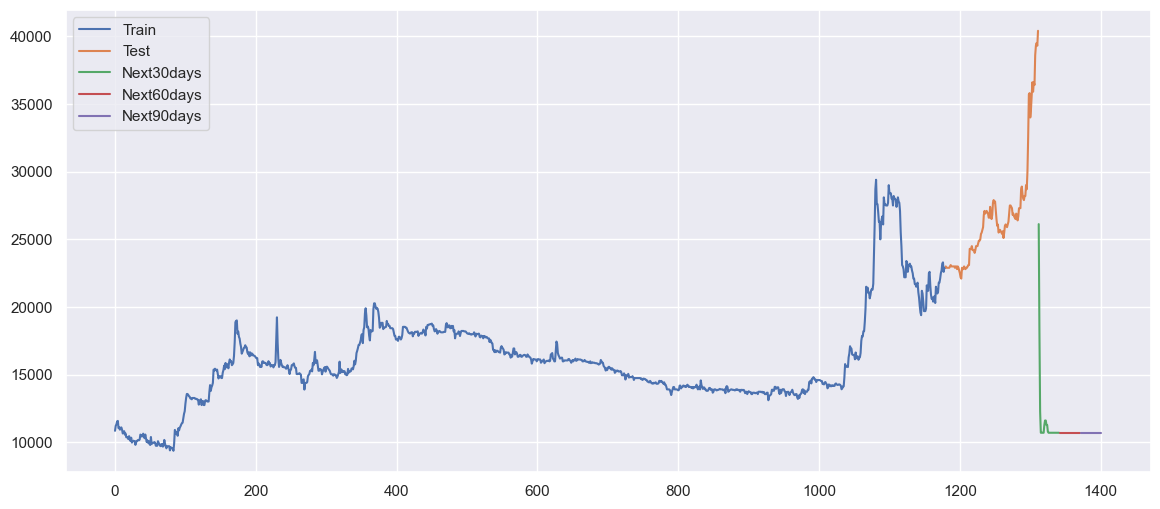

In [55]:
# Plotting train, test, and prediction data
plt.figure(figsize=(14, 6))

# Plotting the training data
train_data_index = pd.RangeIndex(start=0, stop=len(train_target), step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_target), label='Train')

# Plotting the testing data
test_data_index = pd.RangeIndex(start=len(train_target), stop=len(train_target) + len(test_target), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_target), label='Test')

# Creating data indices for predictions
predict_30_data_index = pd.RangeIndex(start=len(df), stop=len(df) + 30, step=1)
plt.plot(predict_30_data_index, next_30_days_predictions, label='Predict30days')

predict_60_data_index = pd.RangeIndex(start=len(df) + 30, stop=len(df) + 60, step=1)
plt.plot(predict_60_data_index, next_60_days_predictions[30:], label='Predict60days')

predict_90_data_index = pd.RangeIndex(start=len(df) + 60, stop=len(df) + 90, step=1)
plt.plot(predict_90_data_index, next_90_days_predictions[60:], label='Predict90days')

plt.legend(['Train', 'Test', 'Next30days', 'Next60days', 'Next90days'])
plt.show()

DP3 Historical Data

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import joblib

sns.set_theme()

In [57]:
# Load and preprocess the data
df = pd.read_csv('DP3 Historical Data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)
df = df.replace(',', '', regex=True)

In [58]:
def convert_volume_to_number(volume_str):
    # Check if input is already a float
    if isinstance(volume_str, float):
        return volume_str  # Return float values unchanged
    
    # Handle string inputs
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)

# Apply the function to the "Vol." column
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

In [59]:
def convert_to_numeric(value):
    if isinstance(value, str):
        value = value.strip()
        if value.endswith('%'):
            try:
                return float(value[:-1]) / 100.0  # Convert percentage to float
            except ValueError:
                return value  # Return original value if conversion fails
        elif value.isdigit():
            return int(value)  # Convert integer strings to integers
        elif '.' in value:
            try:
                return float(value)  # Convert decimal strings to float
            except ValueError:
                return value  # Return original value if conversion fails
    return value  # Return value unchanged if it's not a string or couldn't be converted

In [60]:
# Apply the conversion to the entire dataframe
df = df.applymap(convert_to_numeric)

C:\Users\miynzi\AppData\Local\Temp\ipykernel_7204\638310794.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(convert_to_numeric)


In [61]:
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,73800,73000,73900,73000,1540.0,0.0054
2019-03-04,74900,73800,75200,73800,8340.0,0.0149
2019-03-05,74400,75000,75000,74000,7330.0,-0.0067
2019-03-06,74700,74100,75000,74000,3810.0,0.0040
2019-03-07,76300,75000,76900,74700,11570.0,0.0214
...,...,...,...,...,...,...
2024-05-27,60900,61700,61700,60900,12670.0,-0.0016
2024-05-28,61000,61000,61800,60900,7900.0,0.0016
2024-05-29,61000,62000,62000,61000,7300.0,0.0000


In [62]:
print(df.dtypes)

Price         int64
Open          int64
High          int64
Low           int64
Vol.        float64
Change %    float64
dtype: object


In [63]:
# Select features and target
features = df[['Open', 'High', 'Low', 'Price']].values
target = df['Price'].values

In [64]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(np.array(target).reshape(-1, 1))

In [65]:
# Split data into training and testing sets
train_size = int(0.9 * len(scaled_target))
test_size = len(scaled_target) - train_size

train_features = scaled_features[:train_size]
train_target = scaled_target[:train_size]
test_features = scaled_features[train_size:]
test_target = scaled_target[train_size:]

In [66]:
# Function to create dataset matrix
def create_dataset(features, target, time_step=1):
    dataX, dataY = [], []
    for i in range(len(target) - time_step - 1):
        a = features[i:(i + time_step)]
        dataX.append(a)
        dataY.append(target[i + time_step])
    return np.array(dataX), np.array(dataY)

In [67]:
# Create training and testing datasets
time_step = 30
X_train, y_train = create_dataset(train_features, train_target, time_step)
X_test, y_test = create_dataset(test_features, test_target, time_step)

In [68]:
# Reshape input to be [samples, time steps, features] for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

In [69]:
# Build and train LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
lstm_model.add(LSTM(50, return_sequences=True))
lstm_model.add(LSTM(50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)


Epoch 1/100


c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0733 - val_loss: 4.8980e-04
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0121 - val_loss: 4.3090e-04
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0074 - val_loss: 0.0015
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0062 - val_loss: 3.9905e-04
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0054 - val_loss: 2.8737e-04
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0060 - val_loss: 2.9565e-04
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0051 - val_loss: 5.1606e-04
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0037 - val_loss: 2.0268e-04
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0039 - val_loss: 9.8966e-04
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0049 - val_loss: 0.0016
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0052 - val_loss: 2.4624e-04
Epoch 12/100
16/16 ━━━━━━━━━

In [70]:
# Extract features from LSTM for LightGBM
train_features_lstm = lstm_model.predict(X_train)
test_features_lstm = lstm_model.predict(X_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


In [71]:
# Prepare data for LightGBM
train_data_lgb = lgb.Dataset(train_features_lstm, label=y_train)
test_data_lgb = lgb.Dataset(test_features_lstm, label=y_test, reference=train_data_lgb)

In [72]:
# LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': -1,
    'num_boost_round': 200
}

In [73]:
# Train LightGBM model with early stopping
evals_result = {}
callbacks = [
    lgb.early_stopping(stopping_rounds=10),
    lgb.record_evaluation(evals_result)
]

lgb_model = lgb.train(
    params,
    train_data_lgb,
    num_boost_round=params['num_boost_round'],
    valid_sets=[train_data_lgb, test_data_lgb],
    valid_names=['train', 'valid'],
    callbacks=callbacks
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 992, number of used features: 1
[LightGBM] [Info] Start training from score 0.369314
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\basic.py:335: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


In [74]:
# Predict using LightGBM
y_pred = lgb_model.predict(test_features_lstm, num_iteration=lgb_model.best_iteration)

In [75]:
# Define evaluation metric functions
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [76]:
# Calculate evaluation metrics
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
msle = mean_squared_log_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

In [77]:
# Print evaluation metrics
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')
print(f'Mean Squared Logarithmic Error (MSLE): {msle}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')

Root Mean Squared Error (RMSE): 0.014965855322897612
Mean Absolute Percentage Error (MAPE): 10.516479051309416%
Mean Squared Logarithmic Error (MSLE): 0.0001346034098196677
Mean Squared Error (MSE): 0.0002239768255459028
Mean Absolute Error (MAE): 0.011900866507079609


In [78]:
# Function to predict future days using LSTM and LightGBM
def predict_future_days(lstm_model, lgb_model, initial_data, days=30, time_step=30):
    predictions = []
    input_data = initial_data.copy()

    for _ in range(days):
        # Predict features using LSTM
        lstm_features = lstm_model.predict(input_data)

        # Predict the next day's closing price using LightGBM
        next_close = lgb_model.predict(lstm_features)

        # Append the prediction
        predictions.append(next_close[0])

        # Update the initial data with the new prediction
        new_feature = np.zeros((1, time_step, input_data.shape[2]))
        new_feature[:, :-1, :] = input_data[:, 1:, :]
        new_feature[:, -1, 0] = next_close  # Assuming the next_close is for 'Price'
        input_data = new_feature

    return predictions

In [79]:
# Generate the initial data for prediction (last window of the test set)
initial_data = X_test[-1].reshape(1, X_test.shape[1], X_test.shape[2])

In [80]:
# Predict next 30, 60, and 90 days
next_30_days_predictions = predict_future_days(lstm_model, lgb_model, initial_data, days=30)
next_60_days_predictions = predict_future_days(lstm_model, lgb_model, initial_data, days=60)
next_90_days_predictions = predict_future_days(lstm_model, lgb_model, initial_data, days=90)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

In [81]:
# Inverse transform the predictions
next_30_days_predictions = scaler.inverse_transform(np.array(next_30_days_predictions).reshape(-1, 1))
next_60_days_predictions = scaler.inverse_transform(np.array(next_60_days_predictions).reshape(-1, 1))
next_90_days_predictions = scaler.inverse_transform(np.array(next_90_days_predictions).reshape(-1, 1))

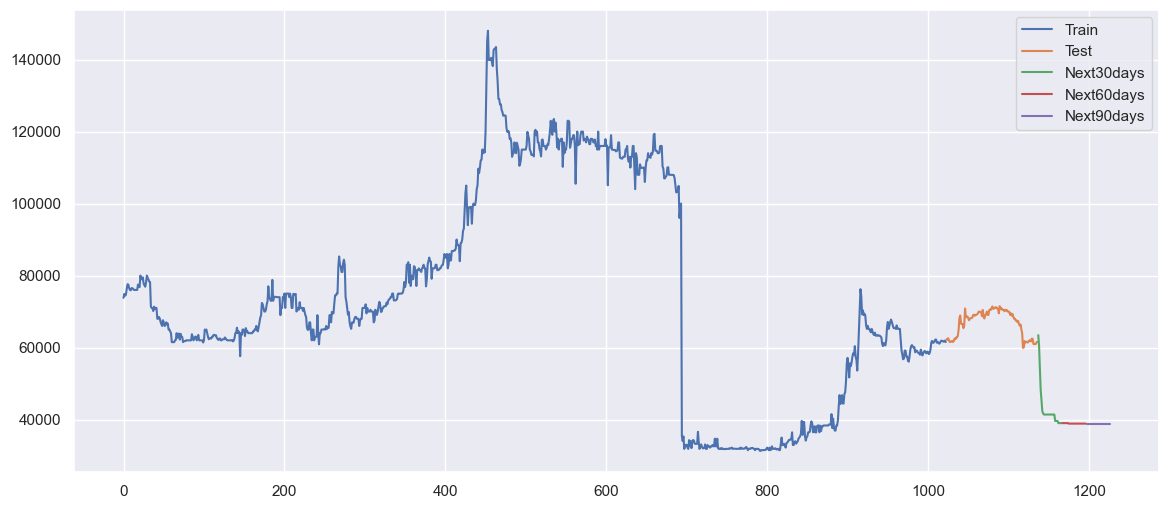

In [82]:
# Plotting train, test, and prediction data
plt.figure(figsize=(14, 6))

# Plotting the training data
train_data_index = pd.RangeIndex(start=0, stop=len(train_target), step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_target), label='Train')

# Plotting the testing data
test_data_index = pd.RangeIndex(start=len(train_target), stop=len(train_target) + len(test_target), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_target), label='Test')

# Creating data indices for predictions
predict_30_data_index = pd.RangeIndex(start=len(df), stop=len(df) + 30, step=1)
plt.plot(predict_30_data_index, next_30_days_predictions, label='Predict30days')

predict_60_data_index = pd.RangeIndex(start=len(df) + 30, stop=len(df) + 60, step=1)
plt.plot(predict_60_data_index, next_60_days_predictions[30:], label='Predict60days')

predict_90_data_index = pd.RangeIndex(start=len(df) + 60, stop=len(df) + 90, step=1)
plt.plot(predict_90_data_index, next_90_days_predictions[60:], label='Predict90days')

plt.legend(['Train', 'Test', 'Next30days', 'Next60days', 'Next90days'])
plt.show()